<div class="alert alert-block alert-info">
Load Data
</div>

In [1]:
using CSV, DataFrames, Dates, HiGHS, JuMP, Statistics, Plots

In [2]:
df = CSV.read("data.csv", DataFrame)
D_t = df[!, "FR_load_forecast_entsoe_transparency"]

println(size(D_t))
println(first(D_t, 5))

df = CSV.read("data.csv", DataFrame)
D_t = df[!, "FR_load_forecast_entsoe_transparency"]

println(size(D_t))
println(first(D_t, 5))
        
file_path = "capacity_pv.csv"
df = CSV.File(file_path; header=true) |> DataFrame
capacity_pv = Array(df)
println(first(capacity_pv, 10))
    
file_path = "capacity_wind.csv"
df = CSV.File(file_path; header=true) |> DataFrame
capacity_wind = Array(df)
println(first(capacity_wind, 10))

(8760,)
[56250.0, 54300.0, 53600.0, 50000.0, 47100.0]
(8760,)
[56250.0, 54300.0, 53600.0, 50000.0, 47100.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.067, 0.218]
[0.12594, 0.123693, 0.124232, 0.13045, 0.140045, 0.136766, 0.129185, 0.135791, 0.152821, 0.14136]


In [3]:
# Load the CSV data
file_path = "Imbalance.csv"
data = CSV.read(file_path, DataFrame)

# The column containing the target data
imbalance_column_name = "Total Imbalance [MWh] - SCA|FR"

# Check if the column is present
if !(imbalance_column_name in names(data))
    error("Column '$imbalance_column_name' not found in the data.")
end

# Extract the "Total Imbalance [MWh] - SCA|FR" data
imbalance_data = data[!, imbalance_column_name]

# Convert non-numeric values to missing values
function to_int(value)
    try
        return parse(Int, value)
    catch
        return missing
    end
end

# Apply the conversion function and filter out missing values
imbalance = filter(!ismissing, to_int.(imbalance_data))

imbalance = first(imbalance,8760)
    
# Set a range for the reserve, ensuring integer output
reserve_range = range(0, stop=maximum(imbalance), length=8760)

# Convert the range to an array of integers
reserve_levels = collect(round.(Int, reserve_range))

println(size(imbalance))
println(first(imbalance,5))
println(last(reserve_levels,5))

(8760,)
Union{Missing, Int64}[489, 922, 630, 416, 356]
[2733, 2733, 2733, 2734, 2734]


<div class="alert alert-block alert-info">
Compute utility function
</div>

8760


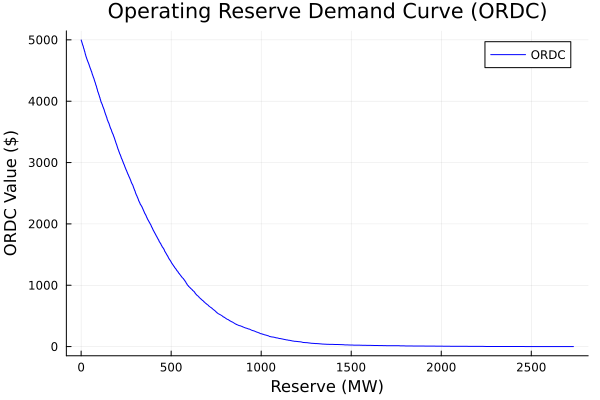

In [4]:
println(length(imbalance))

# Sort the data to calculate the cumulative probability
sorted_data = sort(imbalance)

function compute_lolp(reserve, sorted_imbalance)
    # Probability of an imbalance higher than the given reserve
    return mean(sorted_imbalance .> reserve)
end

reserve_range = range(0, stop=maximum(sorted_data), length=8760)

lolp_values = [compute_lolp(R, sorted_data) for R in reserve_range]

VOLL = 5000

ordc_values = lolp_values .* VOLL

# Plot the ORDC curve
plot(reserve_range, ordc_values, label="ORDC", color=:blue, xlabel="Reserve (MW)", ylabel="ORDC Value (\$)", title="Operating Reserve Demand Curve (ORDC)", legend=:topright, grid=true)

# Discretize the function
# function U(R_t)
#     if R_t < reserve_range[1]
#         return ordc_values[1]
#     elseif R_t > reserve_range[end]
#         return ordc_values[end]
#     else
#         idx = searchsortedlast(reserve_range, R_t)
#         return ordc_values[idx]
#     end
# end

# # Test the U(R_t) function
# println(U(50))  # Example of testing U with a value



<div class="alert alert-block alert-info">
Constant an data
</div>

In [5]:
#utility ORDC
U_ORDC= cumsum(ordc_values)


8760-element Vector{Float64}:
  4996.575342465753
  9993.150684931506
 14989.72602739726
 19986.301369863013
 24971.461187214612
 29956.621004566212
 34941.78082191781
 39917.23744292238
 44892.694063926945
 49868.15068493151
     ⋮
     5.980369292237441e6
     5.980369863013697e6
     5.980370433789953e6
     5.980371004566208e6
     5.980371575342463e6
     5.980372146118719e6
     5.980372716894975e6
     5.980373287671231e6
     5.980373287671231e6

In [6]:
# Constants and Data
T = 8760
lambda = 5000  
cost_of_debt = 0.04
cost_of_equity = 0.07
corporate_tax = 0.30
economic_life = 20
carbon_tax = 50 

capacity = Dict(
    "Coal" => 1,
    "CCGT" => 1,
    "OCGT" => 1,
    "Onshore Wind" => capacity_wind,
    "Offshore Wind" => capacity_wind,
    "PV" => capacity_pv
)

# Technologies data
technologies = Dict(
    "Coal" => (capex=2000*1000, om=0.03, debt_ratio=0.62, heat_rate=2.4, EA=175.2252157*1000, price =5, C=12, emissions=1.4),
    "CCGT" => (capex=950*1000, om=0.03, debt_ratio=0.56, heat_rate=1.62, EA=85.60445144*1000, price =30, C=48.6, emissions=0.5),
    "OCGT" => (capex=700*1000, om=0.03, debt_ratio=0.6, heat_rate=2.5, EA=61.91153839*1000, price =30, C=75, emissions=0.6),
    "Onshore Wind" => (capex=700*1000, om=0.03, debt_ratio=0.7, heat_rate=0, EA=58.99797384*1000, price =0, C=0, emissions=0.0),
    "Offshore Wind" => (capex=1300*1000, om=0.03, debt_ratio=0.7, heat_rate=0, EA=109.5676657*1000, price =0, C=0, emissions=0.0),
    "PV" => (capex=400*1000, om=0.03, debt_ratio=0.8, heat_rate=0, EA=32.04823387*1000, price =0, C=0, emissions=0.0)
)

technologies_t = Dict(
    "Coal" => (capex=2000*1000, om=0.03, debt_ratio=0.62, heat_rate=2.4, EA=175.2252157*1000, price =5, C=12, emissions=1.4),
    "CCGT" => (capex=950*1000, om=0.03, debt_ratio=0.56, heat_rate=1.62, EA=85.60445144*1000, price =30, C=48.6, emissions=0.5),
    "OCGT" => (capex=700*1000, om=0.03, debt_ratio=0.6, heat_rate=2.5, EA=61.91153839*1000, price =30, C=75, emissions=0.6)
)

#Battery data
F_b=6*1000/20
A_b=1.620627574*1000
eta=0.9

LOLP = [sum(h > R for h in imbalance) / T for R in 0:T]

8761-element Vector{Float64}:
 0.9993150684931507
 0.9970319634703196
 0.9950913242009133
 0.9939497716894977
 0.9914383561643836
 0.9894977168949771
 0.9876712328767123
 0.9853881278538813
 0.9839041095890411
 0.9820776255707763
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

<div class="alert alert-block alert-info">
Question 18
</div>

In [7]:
T = 8760
model = Model(HiGHS.Optimizer)


@variable(model, k[g in keys(technologies)] >= 0)  # Installed capacity
@variable(model, p[g in keys(technologies), t=1:T] >= 0)  # Hourly production
@variable(model, r[g in keys(technologies_t), t=1:T] >= 0)  # Hourly reserve # seulement pour les thermiques
# @variable(model, R[t=1:T]>=0) #Total Hourly Reserve
@variable(model, z[t=1:T, i=1:length(reserve_range)], Bin)  # Binary variable for reserve selection
@variable(model, d[t=1:T] >=0)
#For Battery
@variable(model, k_b>=0 ) 
@variable(model, e[1:T] >= 0)
@variable(model, p_in[1:T] >=0)
@variable(model, p_out[1:T] >=0)


# @objective(model, Min, sum((technologies[g].om * technologies[g].capex + technologies[g].EA )*k[g] + sum(technologies[g].C*p[g,t]  for t in 1:T) for g in keys(technologies))+ (A_b + F_b)* k_b - sum( lambda * d[t] for t in 1:T)
# + carbon_tax * sum(technologies[g].emissions * sum(p[g, t] for t in 1:T) for g in keys(technologies))
# - sum(U(t) for t=1:T))
# @objective(model, Min, sum((technologies[g].om * technologies[g].capex + technologies[g].EA )*k[g] + sum(technologies[g].C*p[g,t]  for t in 1:T) for g in keys(technologies))+ (A_b + F_b)* k_b - sum( lambda * d[t] for t in 1:T)
# + carbon_tax * sum(technologies[g].emissions * sum(p[g, t] for t in 1:T) for g in keys(technologies)) - sum(U_ORDC[argmin(abs(R[t] - r)) for r in reserve_range] for t=1:T))
# Precompute closest indices for each R[t] value


# Define the objective function
@objective(model, Min,
    sum((technologies[g].om * technologies[g].capex + technologies[g].EA) * k[g] +
        sum(technologies[g].C * p[g, t] for t in 1:T) for g in keys(technologies)) +
    (A_b + F_b) * k_b -
    sum(lambda * d[t] for t in 1:T) +
    carbon_tax * sum(technologies[g].emissions * sum(p[g, t] for t in 1:T) for g in keys(technologies)) -
    sum(U_ORDC[i] * z[t, i] for t in 1:T, i = 1:length(reserve_range))
)
#- sum(U_ORDC[R[t]] for t=1:T))
# + sum(LOLP[t] * VOLL * r[g, t] for g in keys(technologies_t), t=1:T) 
    
@constraint(model, [ g in keys(technologies_t), t in 1:T], p[g,t] <= k[g] - r[g,t])
@constraint(model, [ g in keys(technologies), t in 1:T], p[g,t] <= k[g])
@constraint(model, [t in 1:T], d[t]<=D_t[t])
@constraint(model, [t in 1:T], -d[t] + p_out[t] - p_in[t]  + sum( p[g,t] for g in keys(technologies))==0)
@constraint(model, [t in 1:T], e[t]<= 4*k_b)
@constraint(model, [t in 1:T], p_in[t]<=k_b)
@constraint(model, [t in 1:T], p_out[t]<=k_b)
@constraint(model,  e[1]==0)
@constraint(model, [t in 2:T], e[t]== e[t-1] + 1*(sqrt(eta)* p_in[t-1] - 1/sqrt(eta) * p_out[t-1]))
for g in ["Coal", "CCGT", "OCGT"]
    @constraint(model, [t in 1:T], p[g, t] + r[g, t] <= k[g])
end
for t in 1:T
    @constraint(model, p["Onshore Wind", t] <= capacity_wind[t]*k["Onshore Wind"])
    @constraint(model, p["Offshore Wind", t] <= capacity_wind[t]*k["Offshore Wind"])
    @constraint(model, p["PV", t] <= capacity_pv[t]*k["PV"])
end

#reserve constraints
@constraint(model, [t in 1:T], sum(r[g,t] for g in keys(technologies_t))==sum(reserve_range[i] * z[t, i] for i in 1:length(reserve_range)))
# Ensure exactly one `z[t, i]` is 1 for each `t`
@constraint(model, [t = 1:T], sum(z[t, i] for i = 1:length(reserve_range)) == 1)



optimize!(model)
# print("Variables value, p:",JuMP.value.(p))
print("Variables value, k:",value.(k))
print("Variables value, k_b:",value.(k_b))
# print("Variables value, d:",value.(d))
print("Objective value: ", objective_value(model))
print(keys(technologies))
                    
######################################################################################################################
println("\n")

println("\n")
println("Point I")
println("Optimal capacities (kW):")
total_production = 0
production_by_tech = Dict(g => 0.0 for g in keys(technologies))
for g in keys(technologies)
    cap = value(k[g])  # This ensures 'cap' remains a floating-point number
    println("$(g): $(cap) kW")
    for t in 1:T
        production_by_tech[g] += value(p[g, t])  # Accumulate as floating-point values
        total_production += value(p[g, t])  # Keep total production as floating-point
    end
end

println("\n")

println("Point II")
println("Share of each technology in effective production:")
for g in keys(technologies)
    share = production_by_tech[g] / total_production
    println("$(g): $(share * 100) %")
end
println("\n")


println("Point III")
println("Total Production: $(total_production) MWh")
total_cost = objective_value(model)
println("Total Investment and Production Cost: €$(total_cost)")
println("\n")


println("Point IV")
# CO2 Emissions data
emissions = Dict(
    "Coal" => 1.4,
    "CCGT" => 0.5,
    "OCGT" => 0.6,
    "Onshore Wind" => 0.0,
    "Offshore Wind" => 0.0,
    "PV" => 0.0
)

# Calculating CO2 emissionys
total_co2_emissions = sum(emissions[g] * production_by_tech[g] for g in keys(production_by_tech))
println("\nTotal CO2 Emissions: $(total_co2_emissions) tons")
println("\n")


println("Point V")
load_curtailment = sum(max(0, D_t[t] - sum(value(p[g, t]) for g in keys(technologies))) for t in 1:T)
println("Total Load Curtailment: $(load_curtailment) MWh")
println("\n")


println("Point VI")
# Profit calculation per technology
profit_by_tech = Dict()
for g in keys(technologies)
    revenue = lambda * production_by_tech[g]  # Assuming all production is sold at threshold price λ
    cost = technologies[g].capex * value(k[g]) + technologies[g].om * technologies[g].capex * value(k[g]) / economic_life
    profit_by_tech[g] = revenue - cost
end

println("\nProfit by Technology:")
for g in keys(profit_by_tech)
    println("$(g): €$(profit_by_tech[g])")
end

In [ ]:
# # This is pseudocode to calculate pi_R 

# VOLL = 5000 

# function calculate_LOLP(imbalance_data, reserve_level)
#     count_higher_than_reserve = sum(imbalance_data .> reserve_level)
#     return count_higher_than_reserve / length(imbalance_data)
# end

# # Calculate pi_R for each hour
# pi_R = zeros(hours_per_year)
# for t in 1:hours_per_year
#     reserve_level = reserve_levels[t]  # Example data for each hour's reserve level
#     LOLP_value = calculate_LOLP(imbalance, reserve_level)
#     pi_R[t] = LOLP_value * VOLL
# end


# println(first(pi_R,5))